# Raw MRI Data Preprocessing

In [1]:
import numpy as np 
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch
import numpy as np
import cv2
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torchvision.utils as vutils
from torchvision import transforms
import time

In [2]:
nii_paths = pd.read_csv('/kaggle/input/nii-files-path/nii_paths.csv')
nii_paths = np.array(nii_paths['nii_path'])

In [3]:
img_arrs = []
for i in range(200):
    # Get data from the 500th patient
    img = nib.load(nii_paths[i + 500])
    data = img.get_fdata()
    for j in range(40, 90):
        img_arrs.append(data[:, :, j])
img_arrs = np.array(img_arrs)

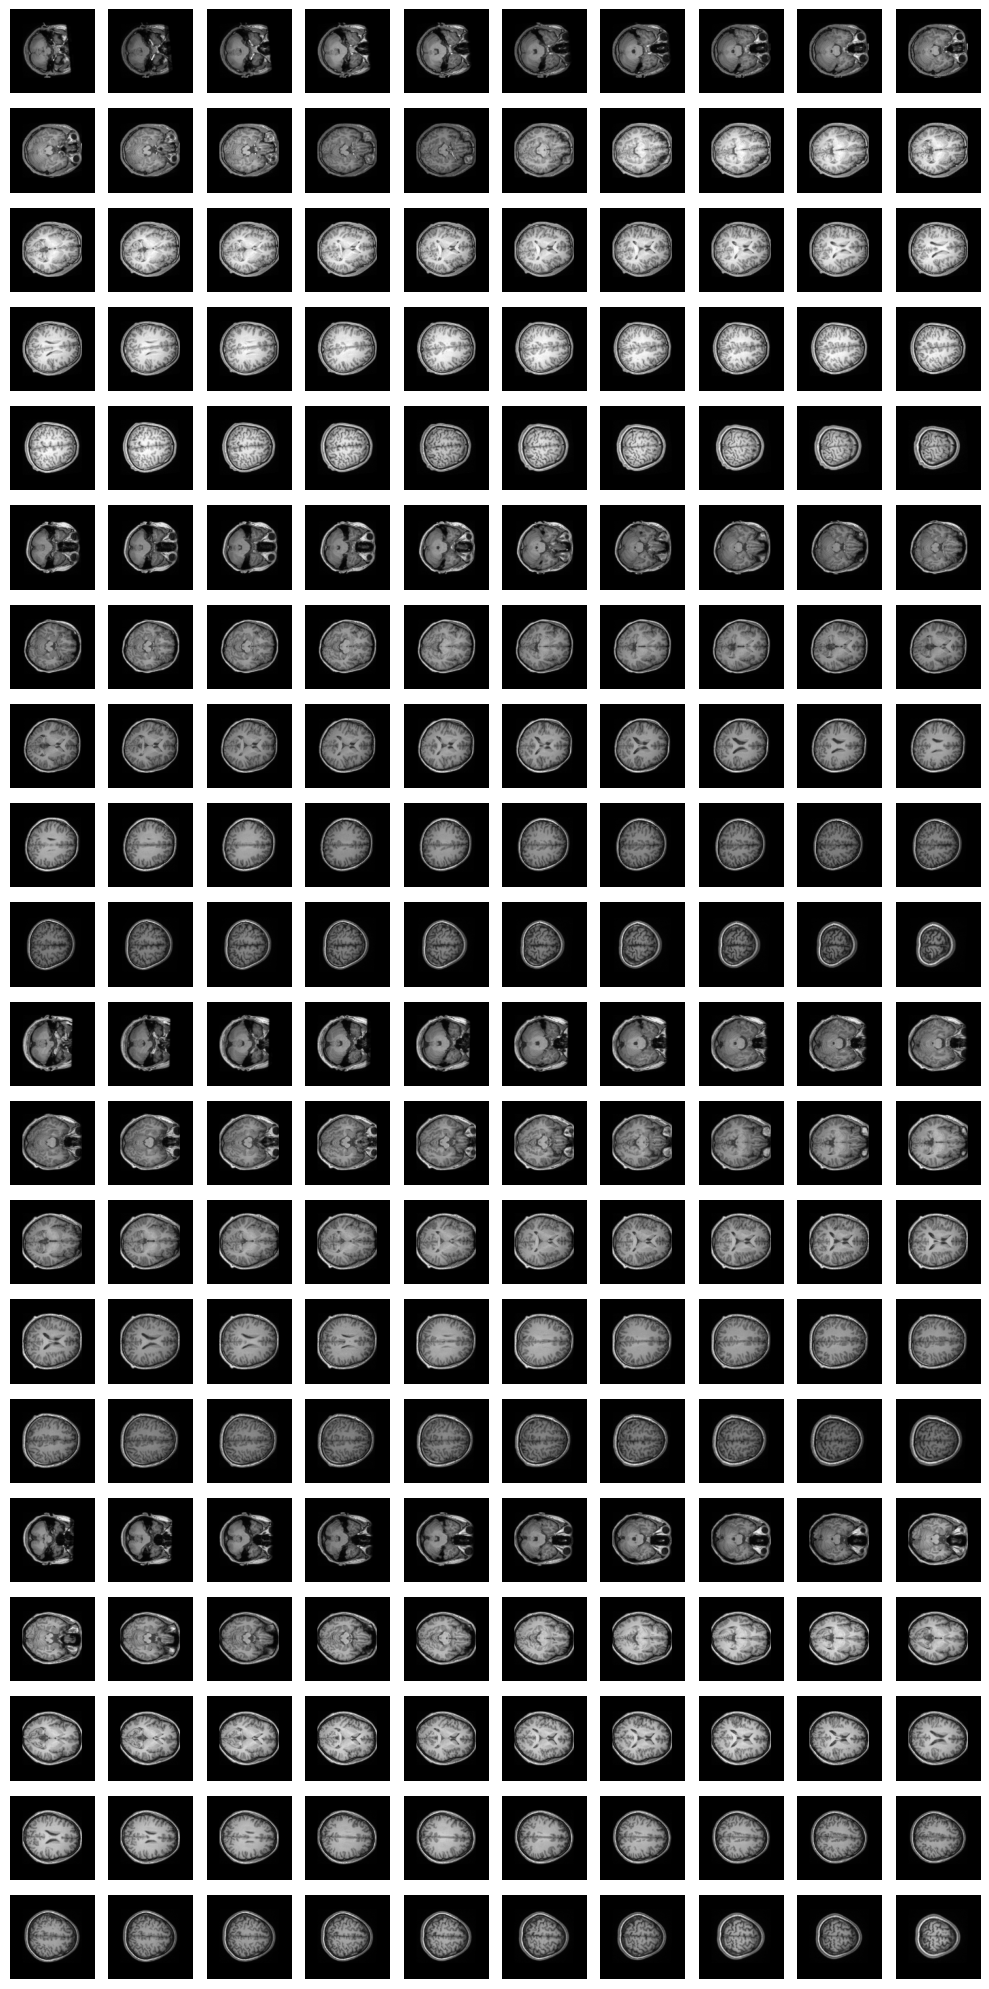

In [4]:
cols = 10
rows = (200 + cols - 1) // cols
plt.figure(figsize=(cols, rows))

for i in range(len(nii_paths[:200])):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_arrs[i], cmap='gray')
    plt.axis('off')
   
plt.tight_layout()
plt.show()

# Configuration Parameters

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LATENT_SIZE = 128       # Latent vector size (input to G)
IMG_SIZE = 128          # Output image size (must match preprocessing)
IMG_CHANNELS = 1        # Number of image channels (1 for MRI grayscale)
EPOCHS = 600            # Number of training epochs
BATCH_SIZE = 32         # Batch size
LR = 0.0001             # Learning rate (Adam: 1e-4 as described)
BETA1 = 0.5             # Adam beta1 parameter (as described)
BETA2 = 0.9             # Adam beta2 parameter (as described)
CRITIC_ITERATIONS = 4   # Number of D updates for each G update
LAMBDA_GP = 10          # Gradient Penalty weight
SAMPLE_INTERVAL = 500   # Frequency of saving sample images (in batches)
MODEL_SAVE_INTERVAL = 10 # Frequency of saving the model (in epochs)
OUTPUT_DIR = Path("/kaggle/working/mri_wgan_output")
# Batch gradient norm clipping threshold
BATCH_MAX_GRAD_NORM = 1.0
# Multiplier for noise standard deviation (needs tuning)
# A larger value means more noise, more privacy, but potentially affects accuracy
NOISE_MULTIPLIER = 0.5

# Data Preprocessing: Resize and Special Normalization for MRI Images

In [6]:
print(f"Starting specialized preprocessing for MRI images...")
start_time = time.time()

num_images = img_arrs.shape[0]
img_arrs_processed_np = np.empty((num_images, IMG_SIZE, IMG_SIZE), dtype=np.float32)

for i in range(num_images):
    img = img_arrs[i]
    p2, p98 = np.percentile(img, (2, 98))
    img_windowed = np.clip(img, p2, p98)
    denominator = (p98 - p2) + 1e-6 # Add a small epsilon to prevent division by zero
    img_normalized = (img_windowed - p2) / denominator
    img_resized = cv2.resize(img_normalized, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
    img_final = img_resized * 2.0 - 1.0 # Scale to [-1, 1] for Tanh output
    img_arrs_processed_np[i] = img_final

    if (i + 1) % 5000 == 0:
        print(f"  Processed {i + 1}/{num_images} images...")

img_arrs_processed_np = np.expand_dims(img_arrs_processed_np, axis=1)
img_tensor = torch.from_numpy(img_arrs_processed_np)

Starting specialized preprocessing for MRI images...
  Processed 5000/10000 images...
  Processed 10000/10000 images...


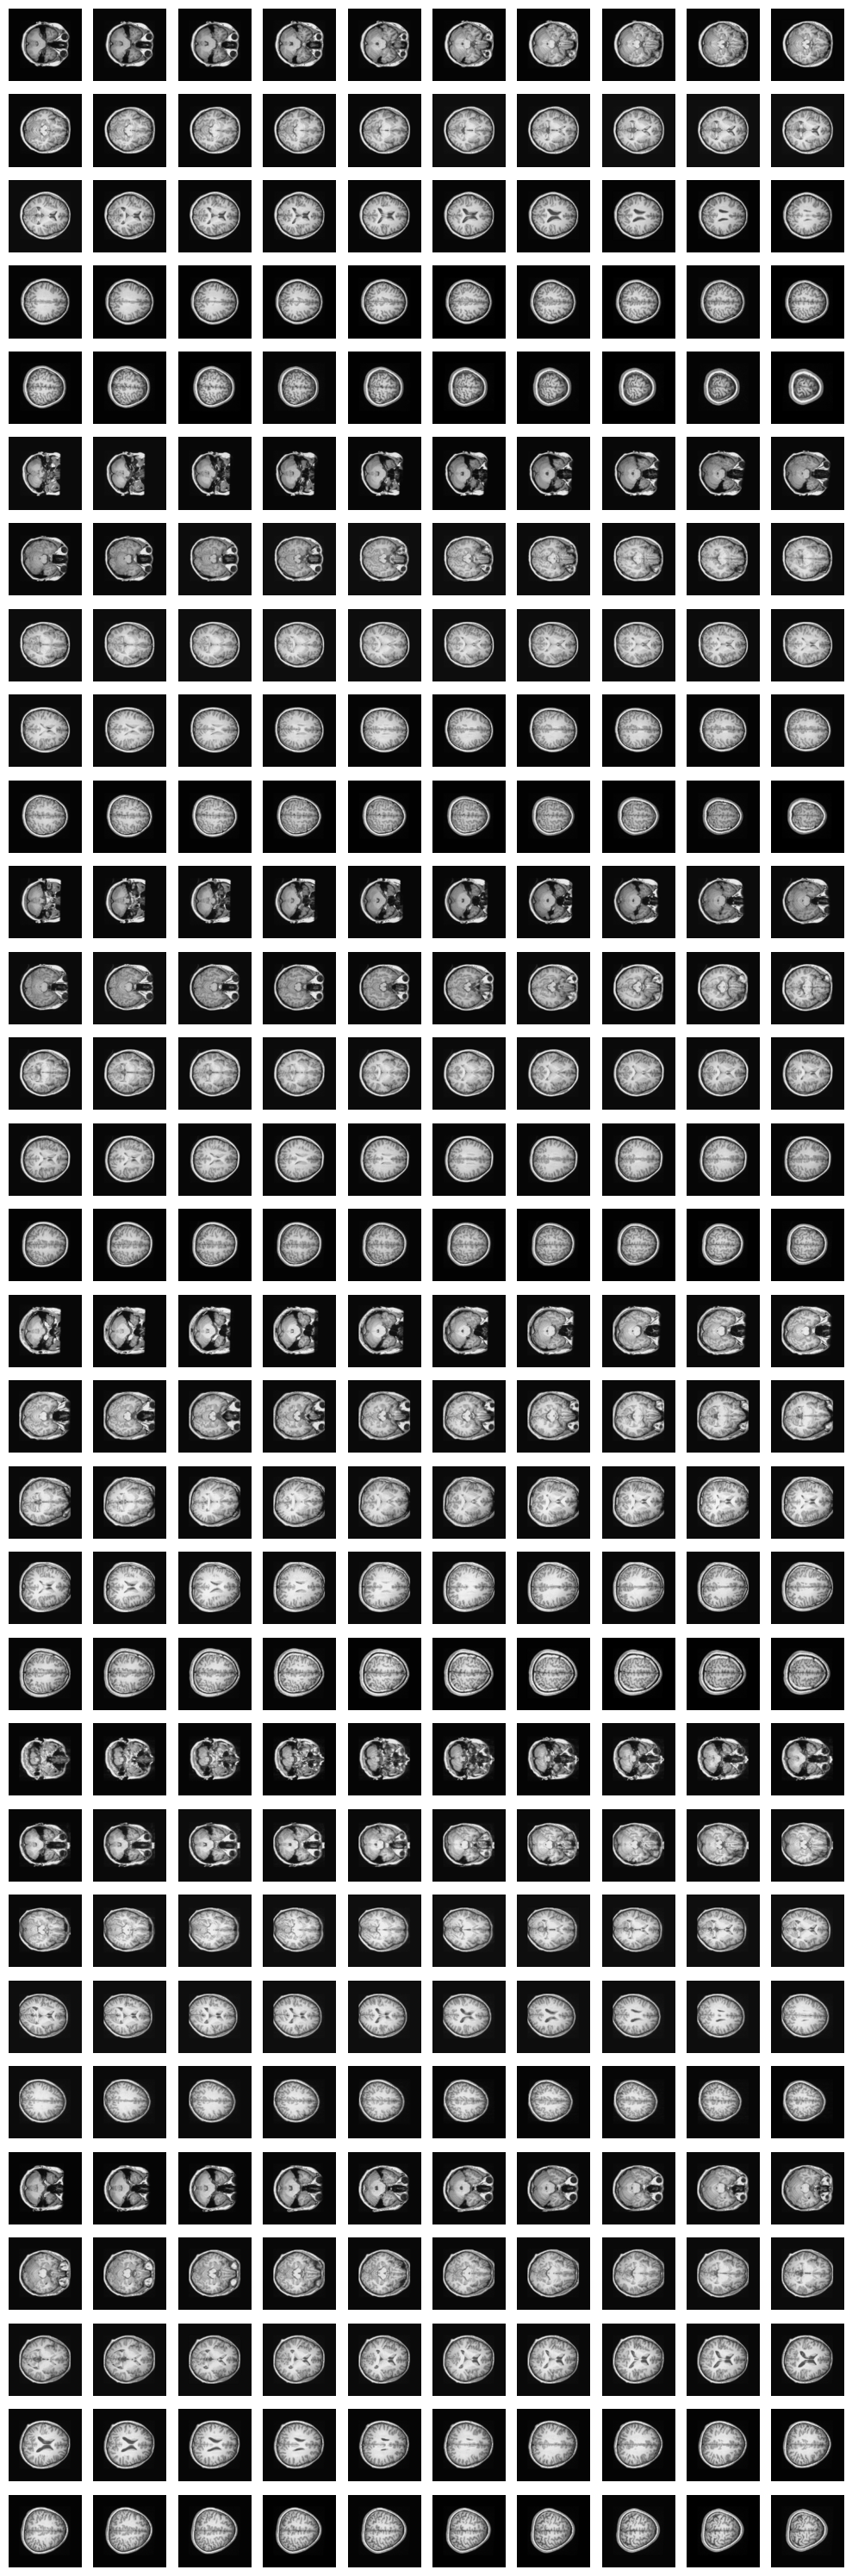

In [7]:
import matplotlib.pyplot as plt

cols = 10
rows = (len(img_arrs[:300]) + cols - 1) // cols
plt.figure(figsize=(cols, rows))

for i in range(len(img_arrs_processed_np[:300])):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_arrs_processed_np[i + 600][0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Create DataLoader

In [8]:
print("Creating DataLoader...")
real_dataset = TensorDataset(img_tensor)
dataloader = DataLoader(
    real_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
print(f"DataLoader ready with {len(dataloader)} batches.")

Creating DataLoader...
DataLoader ready with 313 batches.


# Create Generator

In [9]:
import torch
import numpy as np
import cv2
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torchvision.utils as vutils
from torchvision import transforms
import matplotlib.pyplot as plt
import time
from pathlib import Path

In [10]:
class Generator(nn.Module):
    def __init__(self, latent_size, img_channels, img_size, features_g=64):
        """
        Initializes the Generator.
        Args:
            latent_size (int): Size of the input noise vector z.
            img_channels (int): Number of channels in the output image (e.g., 1 for grayscale).
            img_size (int): Height/width of the output image.
            features_g (int): Base number of features for convolutional layers.
        """
        super(Generator, self).__init__()
        self.img_size = img_size
        self.init_size = img_size // 16  # Initial spatial size (e.g., 128 // 16 = 8)
        self.latent_size = latent_size
        self.img_channels = img_channels

        # Initial Dense layer to transform the z vector
        # Output: features_g * 8 * init_size * init_size
        self.fc = nn.Sequential(
            nn.Linear(latent_size, features_g * 8 * self.init_size * self.init_size),
            # BatchNorm1d applied over flattened features
            nn.BatchNorm1d(features_g * 8 * self.init_size * self.init_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Sequence of ConvTranspose2d blocks for upsampling
        self.conv_blocks = nn.Sequential(
            # Input: (N, features_g * 8, init_size, init_size) - e.g., (N, 512, 8, 8)
            # Block 1: init_size -> init_size * 2 (e.g., 8x8 -> 16x16)
            nn.ConvTranspose2d(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # -> (N, features_g * 4, init_size*2, init_size*2) - e.g., (N, 256, 16, 16)

            # Block 2: init_size * 2 -> init_size * 4 (e.g., 16x16 -> 32x32)
            nn.ConvTranspose2d(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_g * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # -> (N, features_g * 2, init_size*4, init_size*4) - e.g., (N, 128, 32, 32)

            # Block 3: init_size * 4 -> init_size * 8 (e.g., 32x32 -> 64x64)
            nn.ConvTranspose2d(features_g * 2, features_g, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.LeakyReLU(0.2, inplace=True),
            # -> (N, features_g, init_size*8, init_size*8) - e.g., (N, 64, 64, 64)

            # Block 4: init_size * 8 -> init_size * 16 (img_size) (e.g., 64x64 -> 128x128)
            nn.ConvTranspose2d(features_g, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            # -> (N, img_channels, img_size, img_size) - e.g., (N, 1, 128, 128)

            # Final activation is Tanh to map values to [-1, 1]
            nn.Tanh()
        )
        print("Generator initialized:")
        print(f" - Latent size: {latent_size}")
        print(f" - Initial spatial size: {self.init_size}x{self.init_size}")
        print(f" - Base features: {features_g}")
        print(f" - Output image size: {img_size}x{img_size}x{img_channels}")


    def forward(self, z):
        """
        Forward pass through the Generator.
        Args:
            z (Tensor): Input noise vector, shape (batch_size, latent_size).
        Returns:
            Tensor: Generated image, shape (batch_size, img_channels, img_size, img_size).
        """
        # 1. Through Dense layer and reshape
        out = self.fc(z)
        # Reshape to (batch_size, features, init_size, init_size)
        out = out.view(out.size(0), -1, self.init_size, self.init_size)

        # 2. Through ConvTranspose blocks
        img = self.conv_blocks(out)
        return img

In [11]:
def test_generator(generator_class, latent_size, img_channels, img_size, batch_size, device, output_dir):
    """
    Tests the basic functionality of the Generator class.

    Args:
        generator_class: The Generator class to be tested.
        latent_size (int): Size of the noise vector.
        img_channels (int): Number of output image channels.
        img_size (int): Size of the output image.
        batch_size (int): Number of sample images to generate for testing.
        device (torch.device): Device (CPU/GPU) to run the test on.
        output_dir (Path): Directory to save sample images.
    """
    print("\n--- Testing Generator ---")
    try:
        # 1. Initialize Generator
        generator = generator_class(latent_size, img_channels, img_size).to(device)
        generator.eval() # Set to evaluation mode (important for BatchNorm)
        print(f"Generator instantiated successfully on {device}.")

        # 2. Create input noise
        test_noise = torch.randn(batch_size, latent_size, device=device)
        print(f"Input noise shape: {test_noise.shape}")

        # 3. Generate fake images (no gradient calculation needed)
        with torch.no_grad():
            fake_images = generator(test_noise)
        print("Forward pass completed.")

        # 4. Check output shape
        expected_shape = (batch_size, img_channels, img_size, img_size)
        if fake_images.shape == expected_shape:
            print(f"Output shape check: PASSED (Got: {fake_images.shape}, Expected: {expected_shape})")
        else:
            print(f"Output shape check: FAILED (Got: {fake_images.shape}, Expected: {expected_shape})")
            return False # Stop test if shape is incorrect

        # 5. Check pixel value range
        min_val, max_val = fake_images.min().item(), fake_images.max().item()
        print(f"Output value range: [{min_val:.4f}, {max_val:.4f}]")
        if min_val >= -1.0 and max_val <= 1.0:
             print("Value range check: PASSED (within [-1, 1] as expected from Tanh)")
        elif min_val >= -1.01 and max_val <= 1.01: # Allow small tolerance
             print("Value range check: PASSED (within [-1.01, 1.01], close enough)")
        else:
             print("Value range check: WARNING (Outside [-1, 1]. Check Tanh activation or potential issues.)")

        # 6. Save sample images
        output_dir.mkdir(parents=True, exist_ok=True)
        sample_path = output_dir / "generator_test_samples.png"
        vutils.save_image(fake_images, sample_path, nrow=int(batch_size**0.5), normalize=True)
        print(f"Saved sample generator output grid to: {sample_path}")
        print("--- Generator Test Completed Successfully ---")
        
        # Clear memory (especially important for GPU)
        del generator, test_noise, fake_images
        if torch.cuda.is_available():
             torch.cuda.empty_cache()
             
        return True

    except Exception as e:
        print(f"--- Generator Test FAILED ---")
        import traceback
        print(f"Error during generator test: {e}")
        traceback.print_exc()
        return False

In [12]:
test_batch_size = 16 # Or 8, 4...
test_successful = test_generator(
    generator_class=Generator,
    latent_size=LATENT_SIZE,
    img_channels=IMG_CHANNELS,
    img_size=IMG_SIZE,
    batch_size=test_batch_size,
    device=DEVICE,
    output_dir=OUTPUT_DIR
)

if not test_successful:
    print("Generator test failed. Please review the errors before proceeding.")
    # raise RuntimeError("Generator test failed.") # Uncomment to stop script on failure


--- Testing Generator ---
Generator initialized:
 - Latent size: 128
 - Initial spatial size: 8x8
 - Base features: 64
 - Output image size: 128x128x1
Generator instantiated successfully on cpu.
Input noise shape: torch.Size([16, 128])
Forward pass completed.
Output shape check: PASSED (Got: torch.Size([16, 1, 128, 128]), Expected: (16, 1, 128, 128))
Output value range: [-0.0960, 0.0833]
Value range check: PASSED (within [-1, 1] as expected from Tanh)
Saved sample generator output grid to: /kaggle/working/mri_wgan_output/generator_test_samples.png
--- Generator Test Completed Successfully ---


# Create Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, img_size, features_d=64):
        """
        Initializes the Discriminator (Critic).
        Args:
            img_channels (int): Number of channels in the input image (e.g., 1 for grayscale).
            img_size (int): Height/width of the input image.
            features_d (int): Base number of features for convolutional layers.
        """
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.img_channels = img_channels

        # Sequence of Conv2d layers for downsampling
        # IMPORTANT: Do NOT use BatchNorm in WGAN-GP's Critic
        self.conv_blocks = nn.Sequential(
            # Input: (N, img_channels, img_size, img_size) - e.g., (N, 1, 128, 128)

            # Block 1: 128x128 -> 64x64
            nn.Conv2d(img_channels, features_d, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # -> (N, features_d, img_size/2, img_size/2) - e.g., (N, 64, 64, 64)

            # Block 2: 64x64 -> 32x32
            nn.Conv2d(features_d, features_d * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # -> (N, features_d*2, img_size/4, img_size/4) - e.g., (N, 128, 32, 32)

            # Block 3: 32x32 -> 16x16
            nn.Conv2d(features_d * 2, features_d * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # -> (N, features_d*4, img_size/8, img_size/8) - e.g., (N, 256, 16, 16)

            # Block 4: 16x16 -> 8x8
            nn.Conv2d(features_d * 4, features_d * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # -> (N, features_d*8, img_size/16, img_size/16) - e.g., (N, 512, 8, 8)

             # Block 5: 8x8 -> 4x4 (Add another layer if more depth is needed)
            nn.Conv2d(features_d * 8, features_d * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # -> (N, features_d*16, img_size/32, img_size/32) - e.g., (N, 1024, 4, 4)
        )

        # Final layer to output a scalar score
        # Input after flatten: features_d * 16 * (img_size/32) * (img_size/32)
        # Example: 1024 * 4 * 4 = 16384
        final_feature_map_size = img_size // 32
        self.fc = nn.Sequential(
            nn.Flatten(),
            # No activation here (output is the critic score)
             nn.Linear(features_d * 16 * final_feature_map_size * final_feature_map_size, 1)
        )

        print("Discriminator (Critic) initialized:")
        print(f" - Input image size: {img_size}x{img_size}x{img_channels}")
        print(f" - Base features: {features_d}")
        print(f" - Final feature map size before flatten: {final_feature_map_size}x{final_feature_map_size}")
        print(f" - Output: Scalar score")


    def forward(self, img):
        """
        Forward pass through the Discriminator.
        Args:
            img (Tensor): Input image (real or fake), shape (batch_size, img_channels, img_size, img_size).
        Returns:
            Tensor: Critic score for each image, shape (batch_size, 1).
        """
        # 1. Through Conv2d blocks
        out = self.conv_blocks(img)
        # 2. Through the final fully connected layer
        score = self.fc(out)
        return score

# Custom Weight Initialization

In [14]:
def weights_init(m):
    """
    Custom weight initialization for Conv2d and BatchNorm2d layers.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Calculate Loss

In [15]:
def compute_gradient_penalty(D, real_samples, fake_samples, device, lambda_gp):
    """
    Computes the gradient penalty loss for WGAN-GP.
    Args:
        D (nn.Module): Discriminator (Critic).
        real_samples (Tensor): Batch of real images.
        fake_samples (Tensor): Batch of fake images.
        device (torch.device): Device for computation (CPU/GPU).
        lambda_gp (float): Weight for the gradient penalty.
    Returns:
        Tensor: Gradient penalty loss value.
    """
    
    batch_size = real_samples.size(0)
    # Random alpha for interpolation
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)
    # Create interpolated points between real and fake images
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    # Get critic scores for interpolated points
    d_interpolates = D(interpolates)
    # Create fake gradient outputs (since we want gradients of output w.r.t. input)
    fake = torch.ones(batch_size, 1, device=device, requires_grad=False)

    # Compute gradients of scores w.r.t. interpolated inputs
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,       # Keep graph for higher-order derivatives if needed
        retain_graph=True,       # Retain graph to backprop D's loss
        only_inputs=True,        # Only need gradients of inputs
    )[0]

    # Flatten gradients to compute norm
    gradients = gradients.view(gradients.size(0), -1)
    # Compute L2 norm of gradients and the penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

In [16]:
import os
os.makedirs(f"{OUTPUT_DIR}/images", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/models", exist_ok=True)

# Training

In [17]:
def add_dp_noise_to_gradients(model, noise_multiplier=1.1, max_grad_norm=1.0):
    """Adds DP noise to gradients after clipping."""
    # Clip gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
    
    # Add Gaussian noise
    with torch.no_grad():
        for param in model.parameters():
            if param.grad is not None:
                noise = torch.normal(
                    mean=0.0,
                    std=noise_multiplier * max_grad_norm,
                    size=param.grad.shape,
                    device=param.grad.device
                )
                param.grad.add_(noise)

In [18]:
# # Initialize models and optimizers
# generator = Generator(LATENT_SIZE, IMG_CHANNELS, IMG_SIZE).to(DEVICE)
# discriminator = Discriminator(IMG_CHANNELS, IMG_SIZE).to(DEVICE)

# # Apply custom weight initialization
# generator.apply(weights_init)
# discriminator.apply(weights_init)

# # Initialize optimizers
# optimizer_g = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))
# optimizer_d = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, BETA2))

# # Initialize fixed noise for tracking progress
# fixed_noise = torch.randn(64, LATENT_SIZE, device=DEVICE)

# # Store loss history for later analysis
# g_losses = []
# d_losses = []
# real_scores = []
# fake_scores = []

# print(f"Starting WGAN-GP MRI model training...")
# print(f"Training on {DEVICE}")
# print(f"Parameters: latent={LATENT_SIZE}, batch_size={BATCH_SIZE}, LR={LR}")

# total_batches = len(dataloader)
# global_step = 0
# start_time = time.time()

# for epoch in range(1, EPOCHS + 1):
#     epoch_start_time = time.time()
#     generator.train()
#     discriminator.train()
    
#     # Measure performance for each epoch
#     epoch_g_loss = 0.0
#     epoch_d_loss = 0.0
#     epoch_real_score = 0.0
#     epoch_fake_score = 0.0
#     batches_this_epoch = 0
    
#     for batch_idx, (real_imgs,) in enumerate(dataloader):
#         batches_this_epoch += 1
#         global_step += 1
#         batch_size = real_imgs.size(0)
#         real_imgs = real_imgs.to(DEVICE)
        
#         # ---------------------
#         # Train Discriminator (Critic)
#         # ---------------------
#         for _ in range(CRITIC_ITERATIONS):
#             optimizer_d.zero_grad()
            
#             # Calculate scores for real images
#             real_validity = discriminator(real_imgs)
#             real_score = real_validity.mean().item()
            
#             # Generate fake images
#             z = torch.randn(batch_size, LATENT_SIZE, device=DEVICE)
#             fake_imgs = generator(z)
            
#             # Calculate scores for fake images
#             fake_validity = discriminator(fake_imgs.detach())
#             fake_score = fake_validity.mean().item()
            
#             # Calculate Gradient Penalty
#             gradient_penalty = compute_gradient_penalty(
#                 discriminator, real_imgs.data, fake_imgs.data, DEVICE, LAMBDA_GP
#             )
            
#             # Discriminator loss = -(score of real images - score of fake images) + GP
#             d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + gradient_penalty
            
#             # Backward pass and optimize
#             d_loss.backward()
#             add_dp_noise_to_gradients(discriminator, noise_multiplier=1.1, max_grad_norm=1.0)
#             optimizer_d.step()
            
#         # ---------------------
#         # Train Generator
#         # ---------------------
#         optimizer_g.zero_grad()
        
#         # Generate new fake images
#         z = torch.randn(batch_size, LATENT_SIZE, device=DEVICE)
#         gen_imgs = generator(z)
        
#         # Calculate loss - we want to maximize critic score for fake images
#         validity = discriminator(gen_imgs)
#         g_loss = -torch.mean(validity)
        
#         # Backward pass and optimize
#         g_loss.backward()
#         optimizer_g.step()
        
#         # Store loss information
#         epoch_d_loss += d_loss.item()
#         epoch_g_loss += g_loss.item()
#         epoch_real_score += real_score
#         epoch_fake_score += fake_score
        
#         # Print info and save sample images periodically
#         if global_step % SAMPLE_INTERVAL == 0 or (epoch == 1 and batch_idx == 0):
#             # Switch generator to eval mode to ensure BatchNorm doesn't change
#             generator.eval()
            
#             with torch.no_grad():
#                 fake_samples = generator(fixed_noise).detach().cpu()
            
#             # Save sample images
#             vutils.save_image(
#                 fake_samples,
#                 f"{OUTPUT_DIR}/images/samples_e{epoch:03d}_b{batch_idx:05d}.png",
#                 normalize=True,
#                 nrow=8
#             )
            
#             # Print progress info
#             print(
#                 f"[Epoch {epoch}/{EPOCHS}] "
#                 f"[Batch {batch_idx}/{total_batches}] "
#                 f"[D loss: {d_loss.item():.4f}] "
#                 f"[G loss: {g_loss.item():.4f}] "
#                 f"[Real Score: {real_score:.4f}] "
#                 f"[Fake Score: {fake_score:.4f}]"
#             )
            
#             # Switch generator back to train mode
#             generator.train()
    
#     # Calculate average values for the epoch
#     epoch_d_loss /= batches_this_epoch
#     epoch_g_loss /= batches_this_epoch
#     epoch_real_score /= batches_this_epoch
#     epoch_fake_score /= batches_this_epoch
    
#     # Save model state periodically
#     if epoch % MODEL_SAVE_INTERVAL == 0:
#         torch.save({
#             'epoch': epoch,
#             'generator_state_dict': generator.state_dict(),
#             'discriminator_state_dict': discriminator.state_dict(),
#             'optimizer_g_state_dict': optimizer_g.state_dict(),
#             'optimizer_d_state_dict': optimizer_d.state_dict(),
#             'g_loss': g_loss.item(),
#             'd_loss': d_loss.item(),
#         }, f"{OUTPUT_DIR}/models/wgan_gp_mri_e{epoch:03d}.pt")
    
#     # Store loss history for plotting later
#     g_losses.append(epoch_g_loss)
#     d_losses.append(epoch_d_loss)
#     real_scores.append(epoch_real_score)
#     fake_scores.append(epoch_fake_score)
    
#     # Calculate epoch time and print info
#     epoch_time = time.time() - epoch_start_time
    
#     print(f"Epoch [{epoch}/{EPOCHS}] - Time: {epoch_time:.2f}s")
#     print(f"D Loss: {epoch_d_loss:.4f} | G Loss: {epoch_g_loss:.4f}")
#     print(f"Real Score: {epoch_real_score:.4f} | Fake Score: {epoch_fake_score:.4f}")
    
#     # Plot loss graph every 10 epochs
#     if epoch % 10 == 0:
#         plt.figure(figsize=(15, 5))
        
#         plt.subplot(1, 2, 1)
#         plt.plot(g_losses, label='Generator')
#         plt.plot(d_losses, label='Discriminator')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.title('Generator and Discriminator Loss')
#         plt.legend()
        
#         plt.subplot(1, 2, 2)
#         plt.plot(real_scores, label='Real Scores')
#         plt.plot(fake_scores, label='Fake Scores')
#         plt.xlabel('Epoch')
#         plt.ylabel('Score')
#         plt.title('Discriminator Scores')
#         plt.legend()
        
#         plt.tight_layout()
#         plt.savefig(f"{OUTPUT_DIR}/loss_plots_e{epoch:03d}.png")
#         plt.close()

# # End of training
# training_time = time.time() - start_time
# print(f"Training completed in {training_time/60:.2f} minutes")

# # Save final model
# torch.save({
#     'generator_state_dict': generator.state_dict(),
#     'discriminator_state_dict': discriminator.state_dict(),
# }, f"{OUTPUT_DIR}/models/wgan_gp_mri_final.pt")

# # Plot summary graph
# plt.figure(figsize=(15, 10))

# plt.subplot(2, 1, 1)
# plt.plot(g_losses, label='Generator')
# plt.plot(d_losses, label='Discriminator')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Generator and Discriminator Loss')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(real_scores, label='Real Scores')
# plt.plot(fake_scores, label='Fake Scores')
# plt.xlabel('Epoch')
# plt.ylabel('Score')
# plt.title('Discriminator Scores')
# plt.legend()

# plt.tight_layout()
# plt.savefig(f"{OUTPUT_DIR}/training_progress_summary.png")
# plt.close()

# Using Pre-trained Weights

In [19]:
# Initialize models with the same architecture as when saved
generator = Generator(LATENT_SIZE, IMG_CHANNELS, IMG_SIZE).to(DEVICE)
discriminator = Discriminator(IMG_CHANNELS, IMG_SIZE).to(DEVICE)

# --- 2. Define Checkpoint Path ---
# Change this path to your .pt file
checkpoint_path = "/kaggle/input/wgan-gp-mri-e230/wgan_gp_mri_e230.pt"
# Or a specific checkpoint file like 'wgan_gp_mri_e050.pt'

# --- 3. Load Checkpoint ---
print(f"Loading checkpoint from: {checkpoint_path}")
try:
    # map_location=DEVICE helps load directly to the desired device
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    print("Checkpoint loaded successfully.")

    # --- 4. Load Weights into Model ---
    # Check if necessary keys exist
    if 'generator_state_dict' in checkpoint:
        print("Loading weights into Generator...")
        generator.load_state_dict(checkpoint['generator_state_dict'])
        print("Generator weights loaded.")
    else:
        print("WARNING: 'generator_state_dict' not found in checkpoint.")

    if 'discriminator_state_dict' in checkpoint:
        print("Loading weights into Discriminator...")
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        print("Discriminator weights loaded.")
    else:
        print("WARNING: 'discriminator_state_dict' not found in checkpoint.")

    # --- 5. Set Model Mode ---
    # If you want to use the model for image generation (inference)
    generator.eval()
    discriminator.eval() # D is usually not needed for inference, but set to eval() to be safe
    print(f"Models set to evaluation mode on {DEVICE}.")

    # If you want to continue training from this checkpoint:
    # generator.train()
    # discriminator.train()
    # print(f"Models set to training mode on {DEVICE}.")
    # Note: If continuing training, you also need to load optimizer states
    # if 'optimizer_g_state_dict' in checkpoint and 'optimizer_d_state_dict' in checkpoint:
    #     optimizer_g = optim.Adam(generator.parameters(), lr=...) # Initialize optimizer
    #     optimizer_d = optim.Adam(discriminator.parameters(), lr=...)
    #     optimizer_g.load_state_dict(checkpoint['optimizer_g_state_dict'])
    #     optimizer_d.load_state_dict(checkpoint['optimizer_d_state_dict'])
    #     print("Optimizers states loaded.")
    # if 'epoch' in checkpoint:
    #     start_epoch = checkpoint['epoch'] + 1 # Epoch to resume training from
    #     print(f"Checkpoint saved at end of epoch {checkpoint['epoch']}. Resuming from epoch {start_epoch}.")


except FileNotFoundError:
    print(f"ERROR: Checkpoint file not found at: {checkpoint_path}")
except KeyError as e:
    print(f"ERROR: Key not found in checkpoint file: {e}. Please verify how you saved the file.")
except Exception as e:
    print(f"UNKNOWN ERROR when loading checkpoint: {e}")

Generator initialized:
 - Latent size: 128
 - Initial spatial size: 8x8
 - Base features: 64
 - Output image size: 128x128x1
Discriminator (Critic) initialized:
 - Input image size: 128x128x1
 - Base features: 64
 - Final feature map size before flatten: 4x4
 - Output: Scalar score
Loading checkpoint from: /kaggle/input/wgan-gp-mri-e230/wgan_gp_mri_e230.pt


/tmp/ipykernel_13/2920609352.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=DEVICE)


Checkpoint loaded successfully.
Loading weights into Generator...
Generator weights loaded.
Loading weights into Discriminator...
Discriminator weights loaded.
Models set to evaluation mode on cpu.


Sample images generated using the loaded Generator.


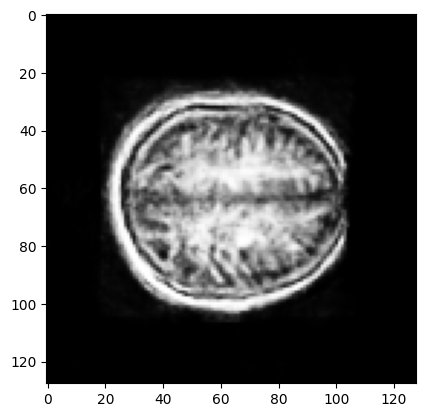

In [20]:
# --- Now you can use the loaded generator ---
# Example: Generate images
if 'generator' in locals() and not generator.training: # Check if generator exists and is in eval mode
    try:
        with torch.no_grad(): # No gradient calculation needed during inference
            fixed_noise = torch.randn(64, LATENT_SIZE, device=DEVICE)
            fake_images = generator(fixed_noise).detach().cpu()
            print("Sample images generated using the loaded Generator.")
            # You can save or display fake_images here
            # import torchvision.utils as vutils
            # vutils.save_image(fake_images, "generated_samples_from_loaded_model.png", normalize=True)
            plt.imshow(fake_images[20][0], cmap='gray')
    except Exception as e:
        print(f"Error generating images with the loaded generator: {e}")